In [16]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from utils import *
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dropout Network

In [17]:
class Dropout_Network(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(Dropout_Network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2*output_dim)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True,)
        
        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer3(x)
        return x

## A Wrapper for Dropout Model

In [34]:
class Dropout_Model:
    def __init__(self, network, learn_rate, weight_decay,y_scale, alpha,lambda_,soften):
        self.learn_rate = learn_rate
        self.y_scale = y_scale
        self.alpha = alpha
        self.lambda_ = lambda_
        self.soften=soften
        self.network = network
        self.network.to(DEVICE)
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        

    def qd_loss(self,pred_U, pred_L, target, pred_mean): 
        N_ = torch.Tensor([target.shape[0]])
        alpha_ = torch.Tensor([self.alpha])
        lambda_ = torch.Tensor([self.lambda_]) 
        soften =torch.Tensor([self.soften]) 
        gamma_U = torch.sigmoid((pred_U - target)*soften)
        gamma_L = torch.sigmoid((target - pred_L)*soften)
        gamma_ = torch.mul(gamma_U, gamma_L)
        PICP_soft = gamma_.mean()
        qd_rhs_soft = lambda_*torch.sqrt(N_)*(torch.max(torch.Tensor([0.]), (1.- alpha_)-PICP_soft))**2
        qd_lhs_soft = ((torch.abs(pred_U - pred_L)*gamma_).sum())/(gamma_.sum()+torch.Tensor([0.001]))
        qd_loss_soft = qd_lhs_soft + qd_rhs_soft
        mse = (((target-pred_mean).mean())**2)*torch.tensor(self.y_scale, dtype=target.dtype)
        
        return qd_loss_soft+mse
    
    def fit(self, X, y):
        self.network.train()
        X, y = X.to(DEVICE), y.to(DEVICE)
        self.optimizer.zero_grad()
        output = self.network(X)
        loss = self.qd_loss(output[:, :1],output[:, 1:], y, output.mean(dim=1))
        loss.backward()
        self.optimizer.step()
        return loss
    
    def predict(self, X, num_samples):
        if num_samples == 1:
            self.network.eval()
        else:
            self.network.train()
        X = X.to(DEVICE)
        pred_Us, pred_Ls, pred_means = [], [],[]         
        for i in range(num_samples):
            output = self.network(X)
            pred_U = output[:, :1, None]
            pred_L = output[:, 1:, None]
            pred_mean = output.mean(dim=1,keepdim=True )[:,:, None]
            pred_Us.append(pred_U)
            pred_Ls.append(pred_L)
            pred_means.append(pred_mean)
        pred_Us = torch.cat(pred_Us, 2)
        pred_Ls =  torch.cat(pred_Ls, 2)
        pred_means = torch.cat(pred_means, 2)
        pred_U = pred_Us.mean(dim=2)
        pred_L = pred_Ls.mean(dim=2)
        pred_mean = pred_means.mean(dim=2)
        return pred_U, pred_L, pred_mean
    
    def evaluate(self, test_loader, num_samples, gamma):
        if gamma == 0.95:
            n_std_devs = 1.96
        elif gamma == 0.90:
            n_std_devs = 1.645
        elif gamma == 0.99:
            n_std_devs = 2.575
        else:
            raise Exception('ERROR unusual gamma')

        pred_U, pred_L,pred_mean,features, target = [],[],[],[],[]
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            batch_pred_U, batch_pred_L, batch_pred_mean = self.predict(X_test, num_samples)
            pred_U.append(batch_pred_U)
            pred_L.append(batch_pred_L)
            pred_mean.append(batch_pred_mean)
            features.append(X_test)
            target.append(y_test)
        pred_U = torch.cat(pred_U, dim=0)
        pred_L = torch.cat(pred_L, dim=0)
        pred_mean = torch.cat(pred_mean, dim=0)
        features = torch.cat(features, dim=0)
        target = torch.cat(target, dim=0) 
        rmse=((pred_mean - target)**2).mean()**0.5
        k_U = torch.max(torch.tensor(0.),torch.sign(pred_U - target))
        k_L = torch.max(torch.tensor(0.),torch.sign(target - pred_L))
        k= torch.mul(k_U, k_L)
        PICP= k.mean()
        MPIW =(pred_U-pred_L).mean()
        rmse = float(rmse.cpu().data)*self.y_scale
        PICP = float(PICP.cpu().data)
        MPIW = float(MPIW.cpu().data)  
        return rmse, PICP, MPIW, pred_mean, pred_U, pred_L, features, target

## Hyper-parameters

In [57]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 1000
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-3
log_every=50
ALPHA = 0.05
LAMBDA_=15
SOFTEN = 160


model_name='Dropout_qd'

## Boston Housing

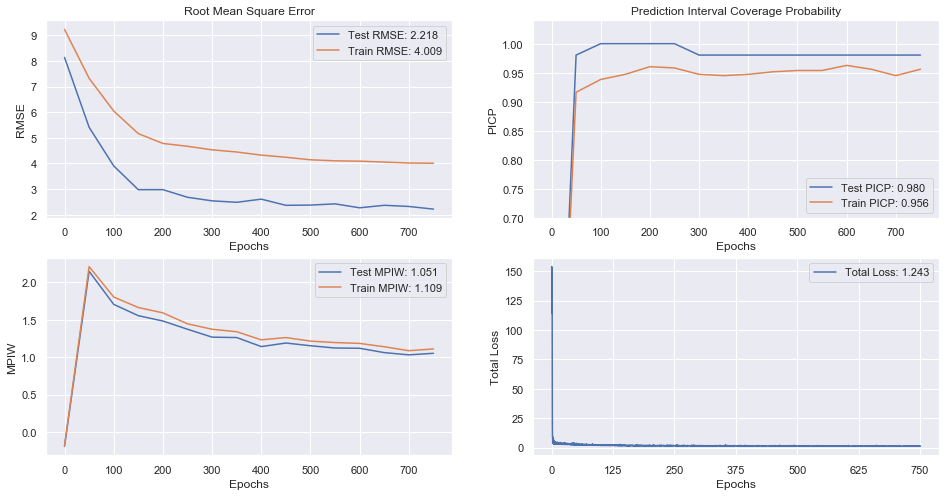

100%|██████████| 800/800 [00:26<00:00, 29.85it/s]


 RMSE = 2.282, PICP = 0.980, MPIW = 1.054


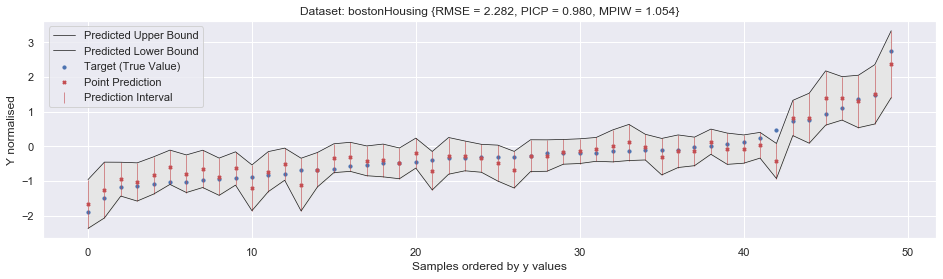

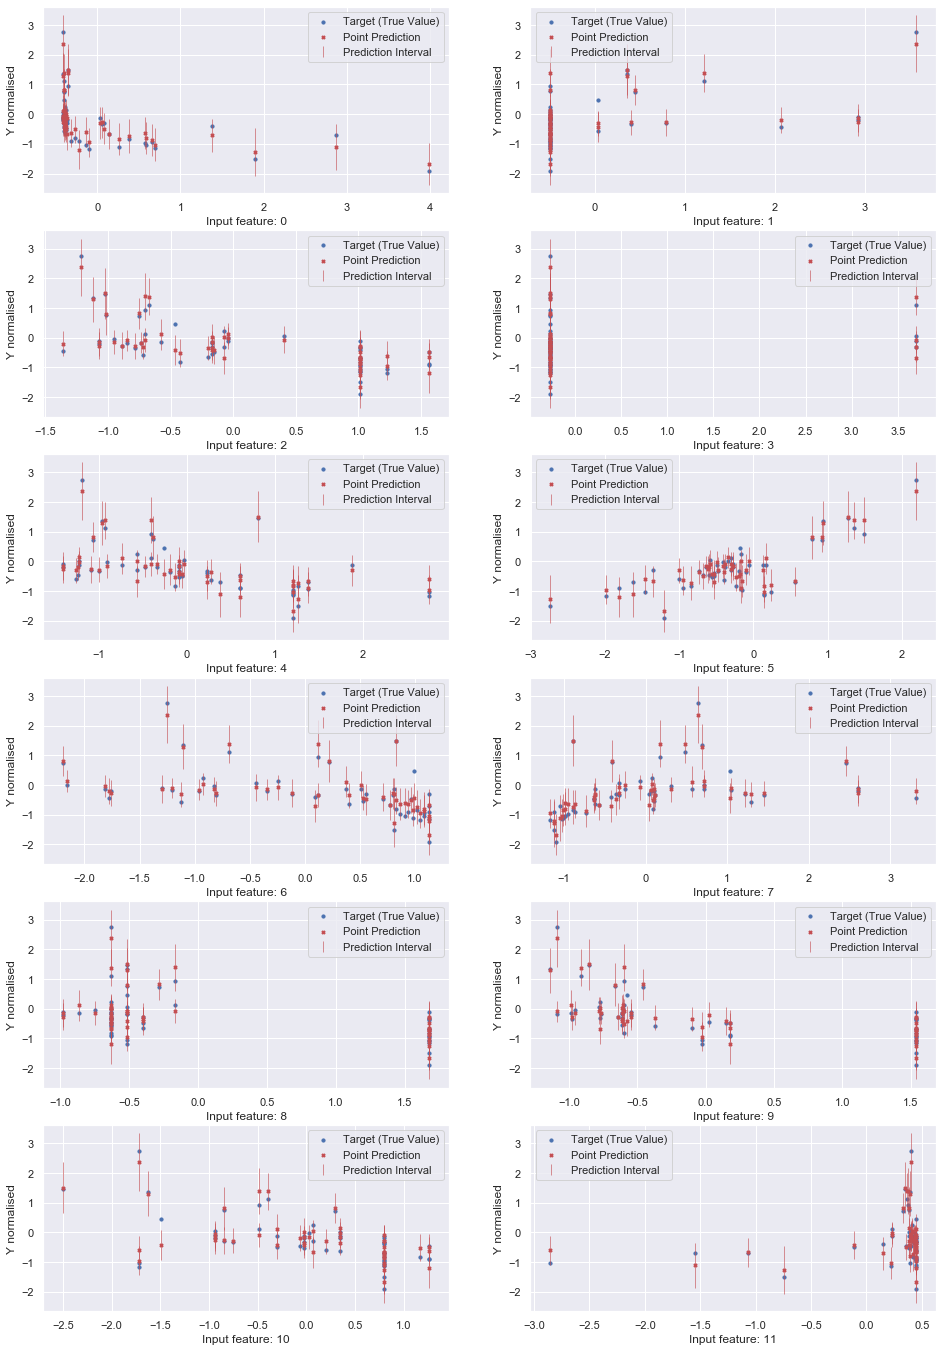

In [44]:
DATA_DIR="bostonHousing"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

bostonHousing_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                                  alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(bostonHousing_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(bostonHousing_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Concrete

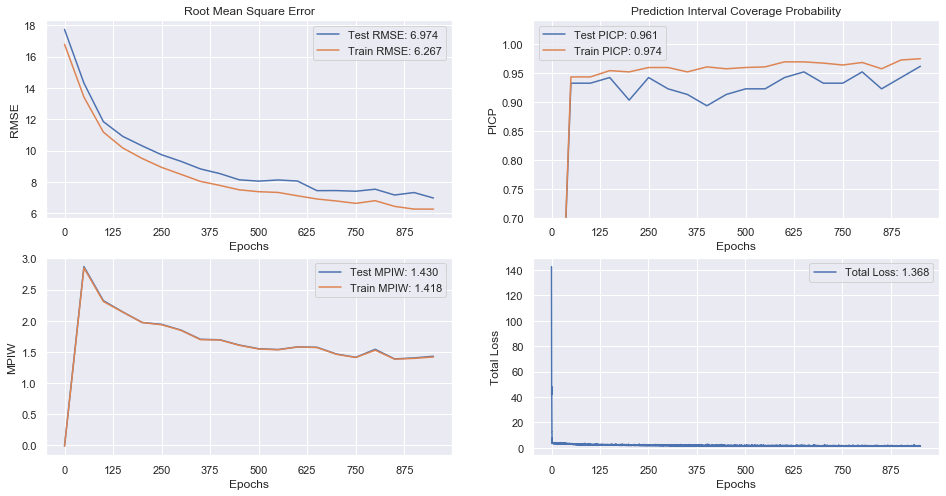

100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


 RMSE = 6.927, PICP = 0.942, MPIW = 1.392


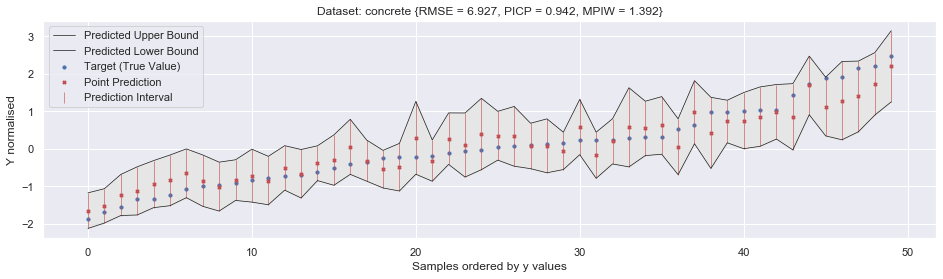

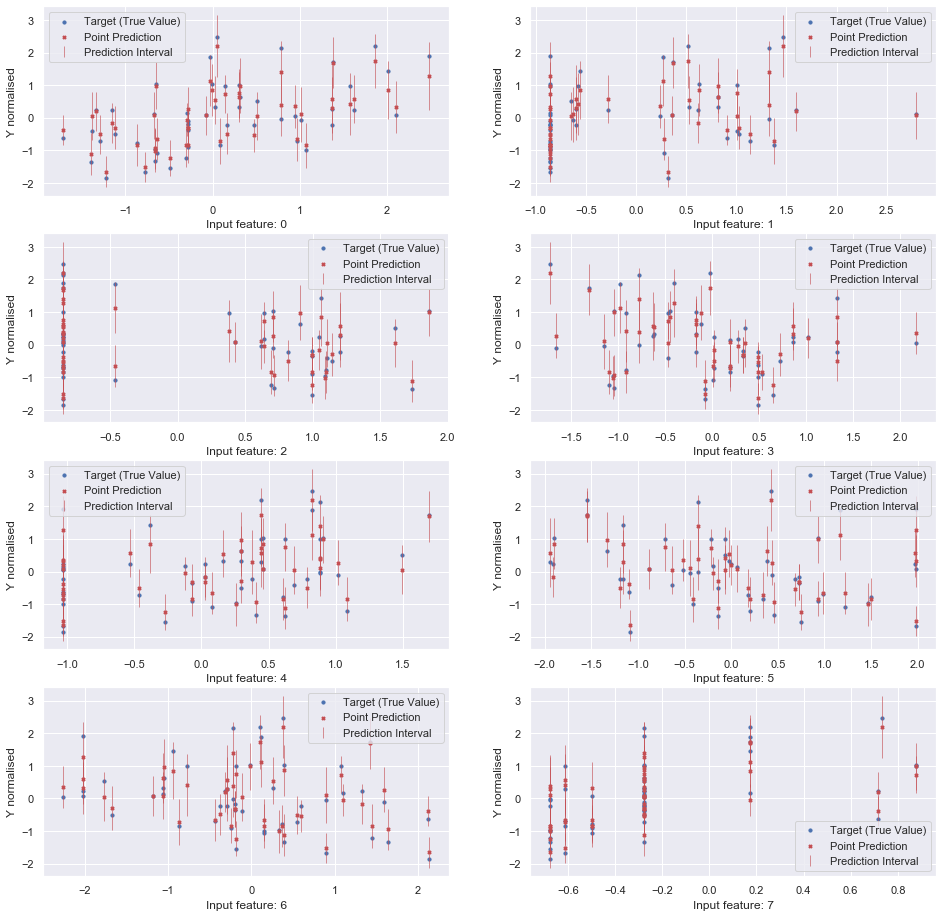

In [47]:
DATA_DIR="concrete"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

concrete_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                             alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(concrete_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(concrete_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## energy_heating_load

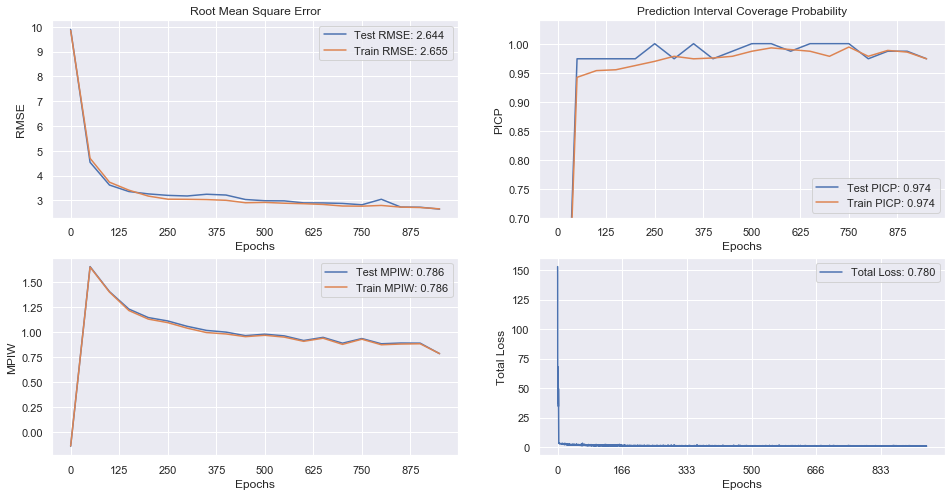

100%|██████████| 1000/1000 [00:44<00:00, 40.46it/s]


 RMSE = 2.580, PICP = 0.987, MPIW = 0.838


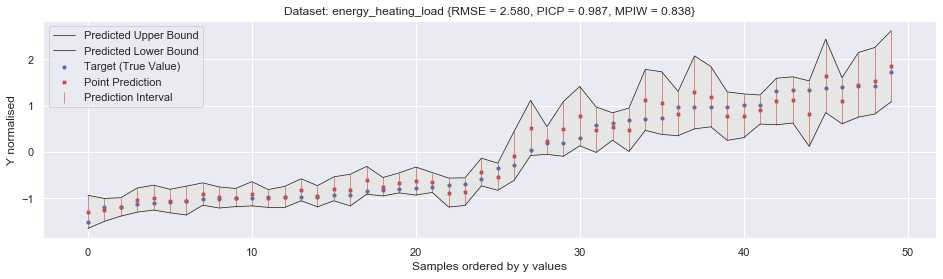

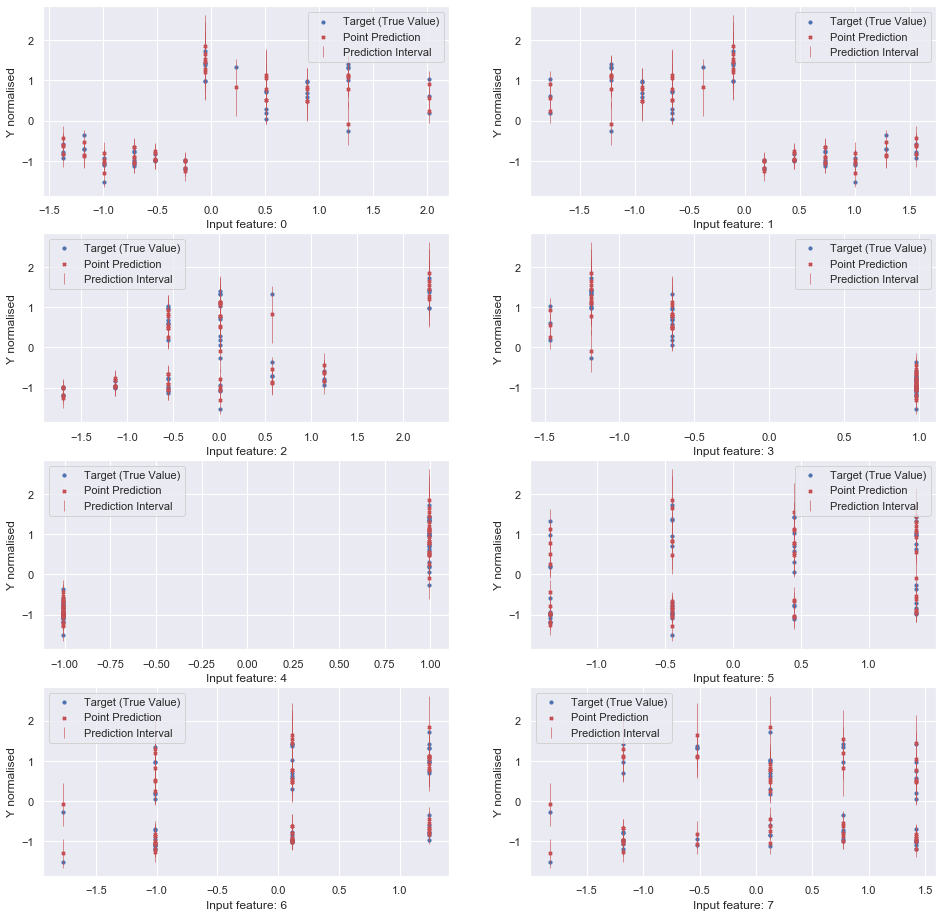

In [48]:
DATA_DIR="energy_heating_load"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

energy_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                           alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(energy_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(energy_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## kin8nm

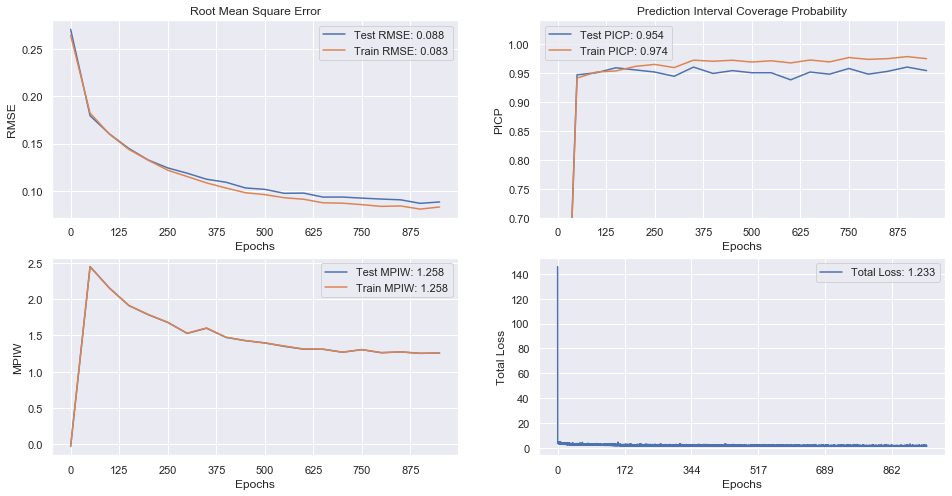

100%|██████████| 1000/1000 [04:39<00:00,  4.11it/s]


 RMSE = 0.087, PICP = 0.960, MPIW = 1.271


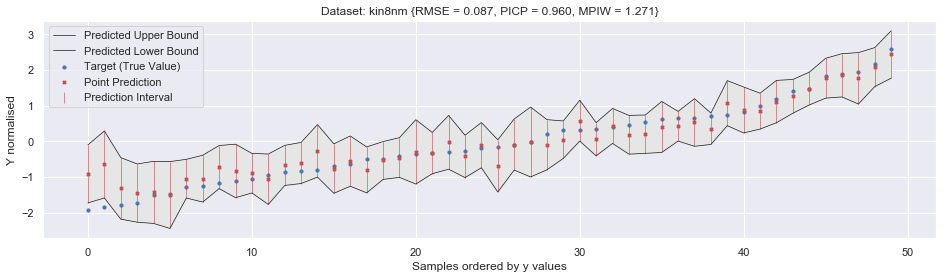

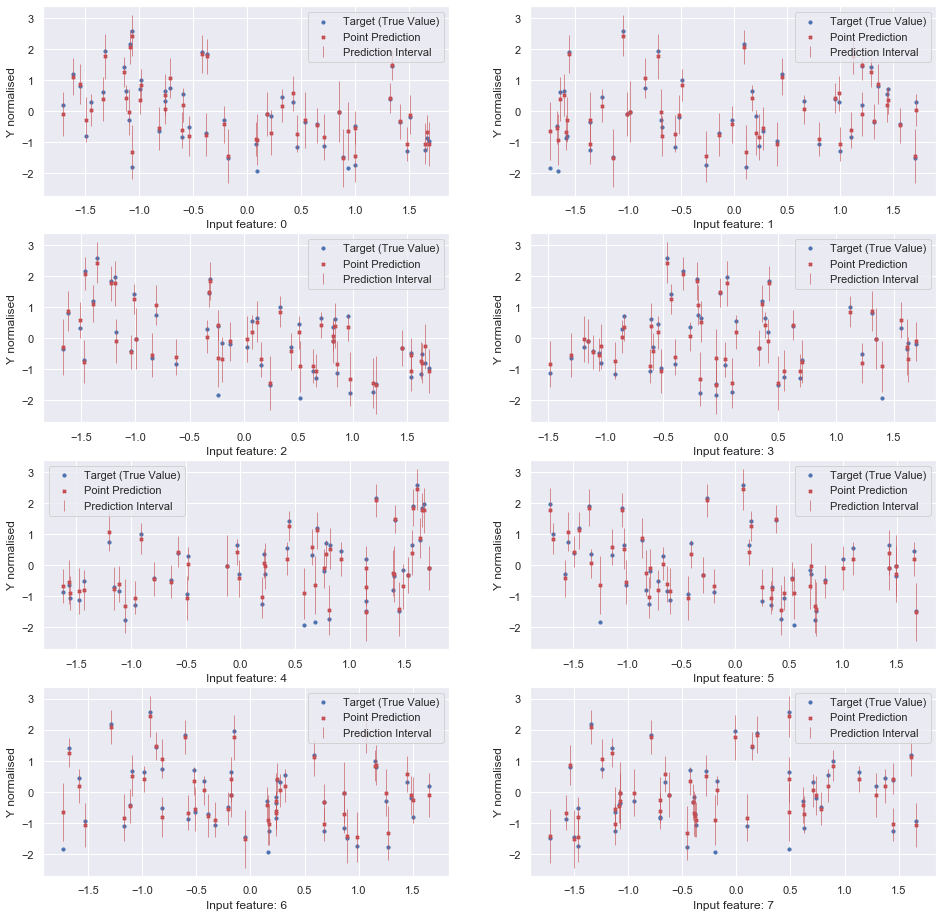

In [49]:
DATA_DIR="kin8nm"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

kin8nm_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                           alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(kin8nm_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(kin8nm_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## Naval

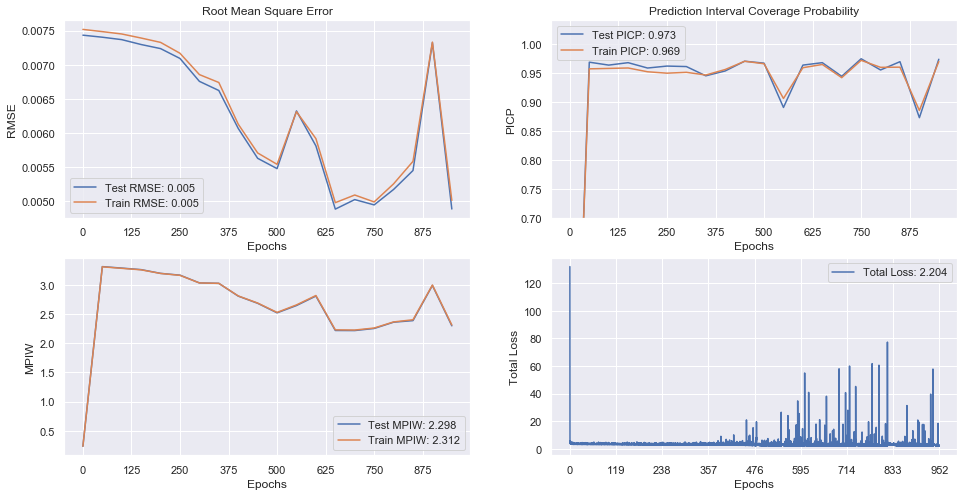

100%|██████████| 1000/1000 [06:43<00:00,  2.84it/s]


 RMSE = 0.005, PICP = 0.951, MPIW = 2.054


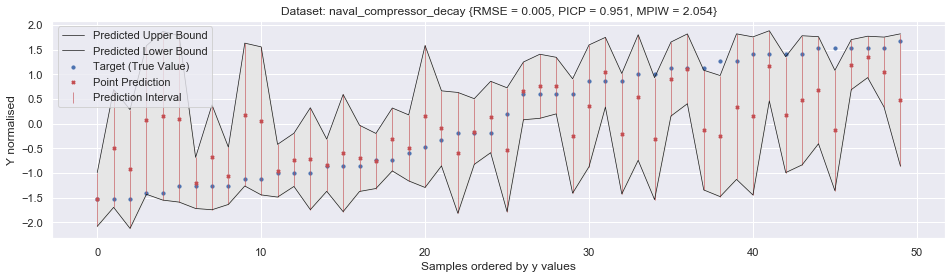

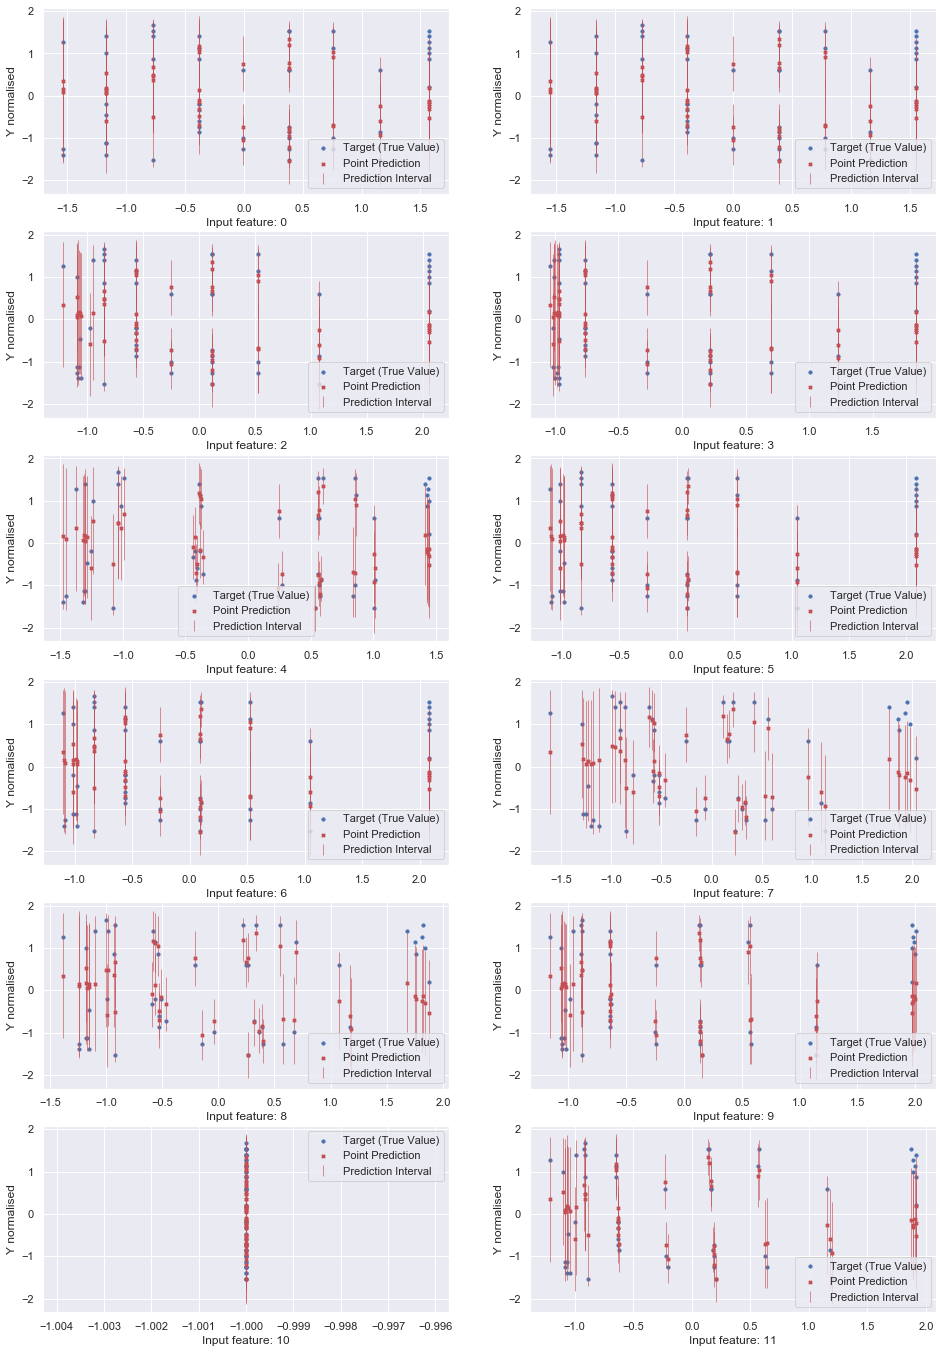

In [51]:
DATA_DIR="naval_compressor_decay"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

naval_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                           alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(naval_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(naval_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)


## power

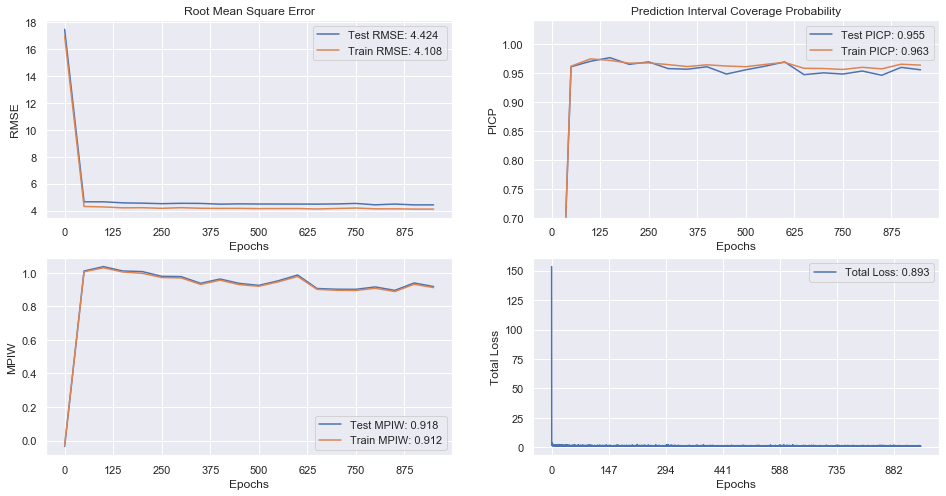

100%|██████████| 1000/1000 [05:17<00:00,  3.39it/s]


 RMSE = 4.440, PICP = 0.952, MPIW = 0.906


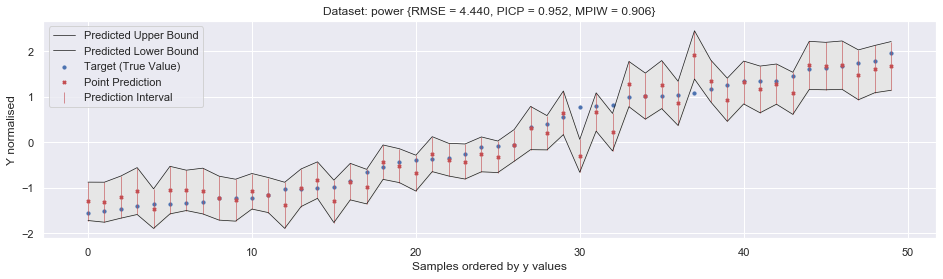

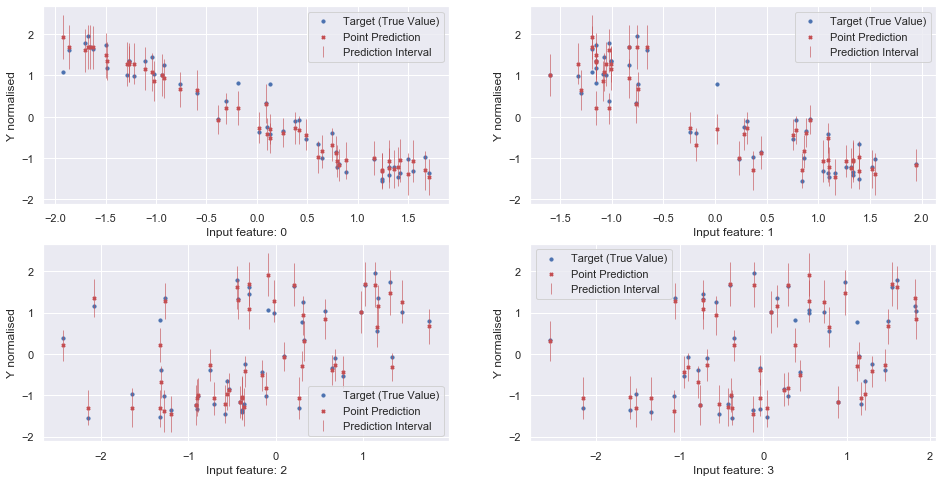

In [52]:
DATA_DIR="power"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

power_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                          alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(power_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(power_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## protein

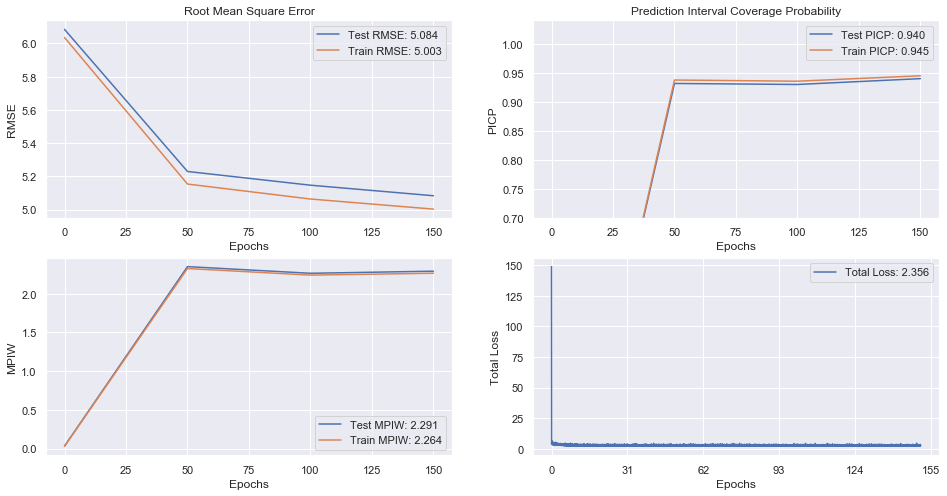

100%|██████████| 200/200 [04:57<00:00,  1.39s/it]


 RMSE = 5.034, PICP = 0.937, MPIW = 2.242


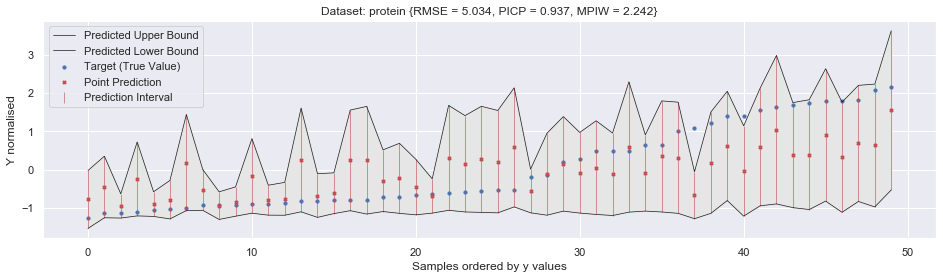

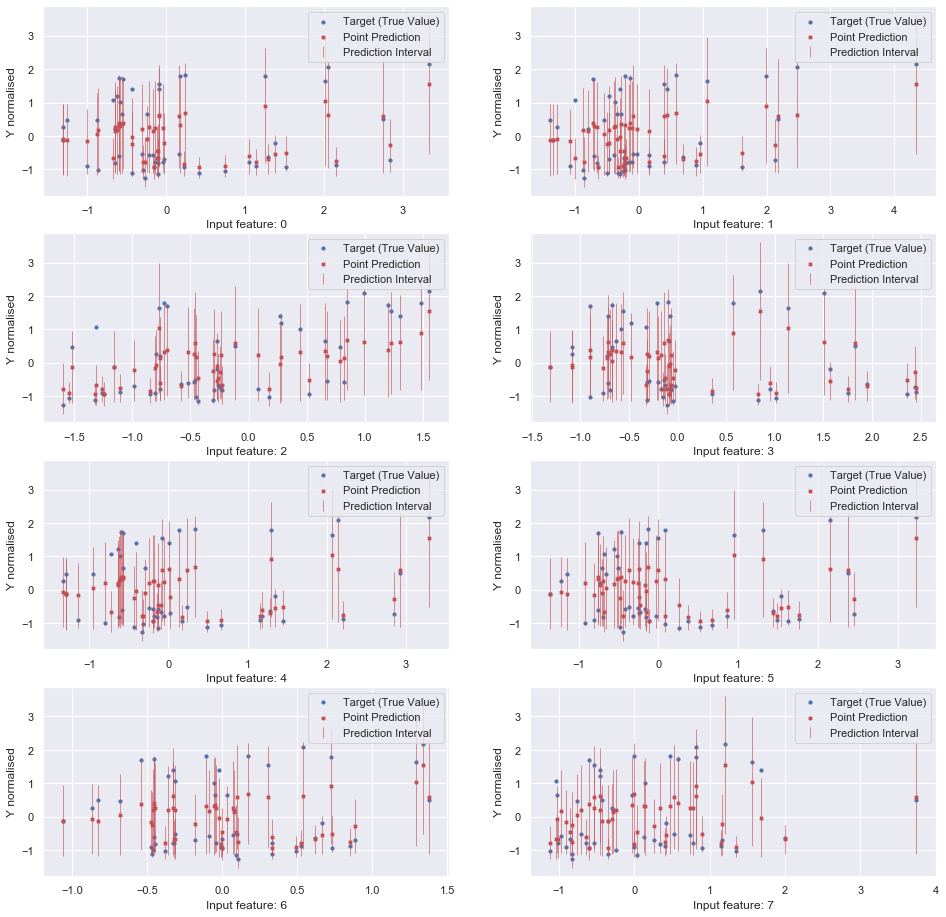

In [53]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 200
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-3
log_every=50
ALPHA = 0.05
LAMBDA_=15
SOFTEN = 160


model_name='Dropout_qd'


DATA_DIR="protein"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

protein_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                            alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(protein_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(protein_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## wine

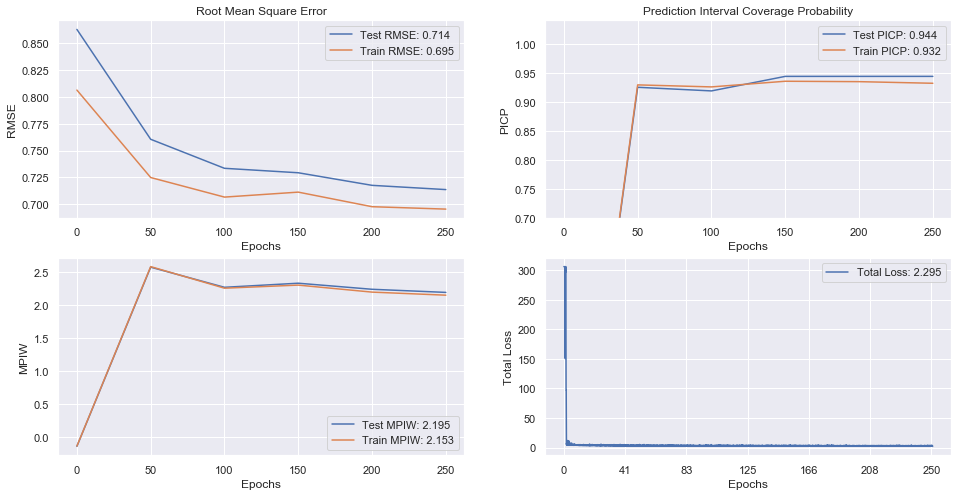

100%|██████████| 300/300 [00:19<00:00, 15.41it/s]


 RMSE = 0.710, PICP = 0.944, MPIW = 2.183


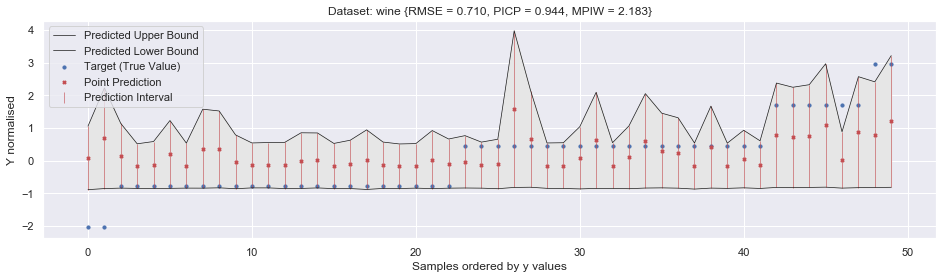

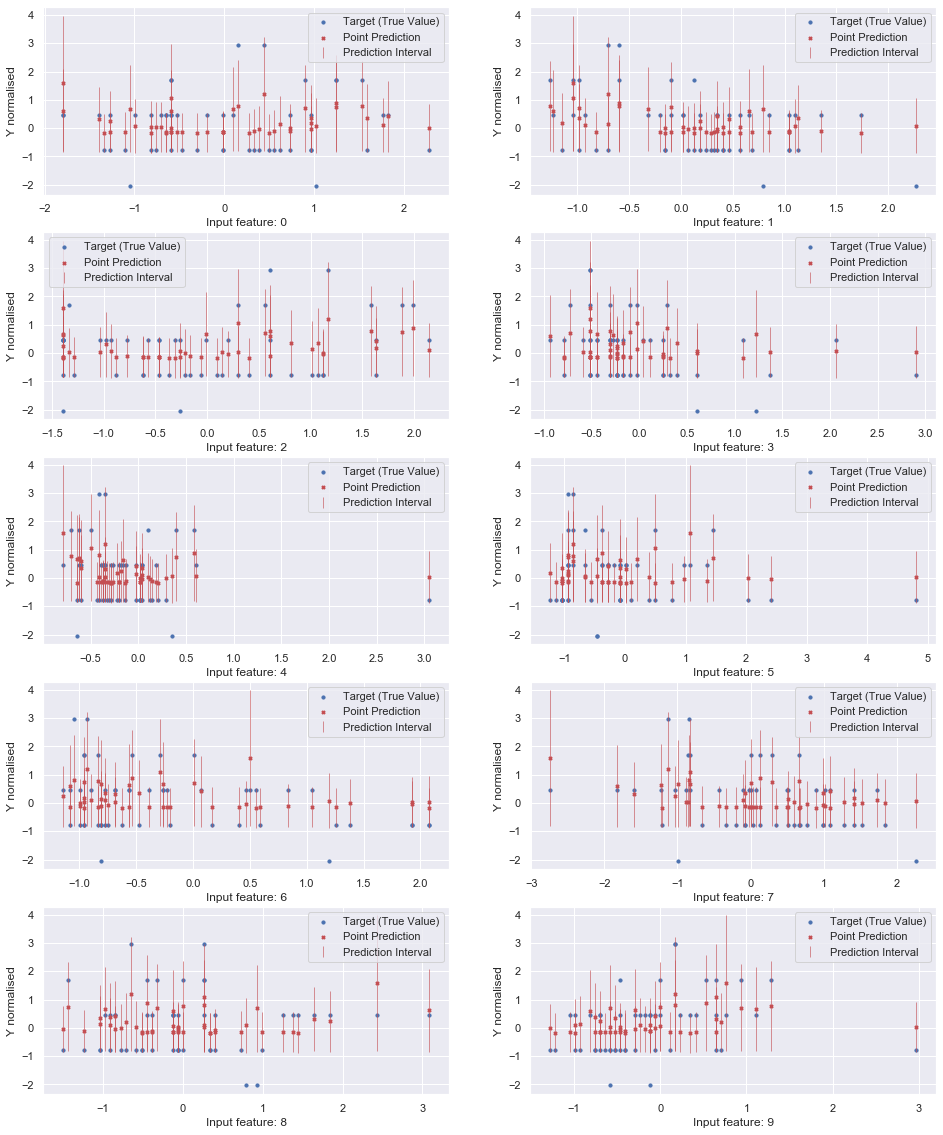

In [56]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 300
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-3
log_every=50
ALPHA = 0.05
LAMBDA_=30
SOFTEN = 160
DATA_DIR="wine"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

wine_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                         alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(wine_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(wine_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## yacht

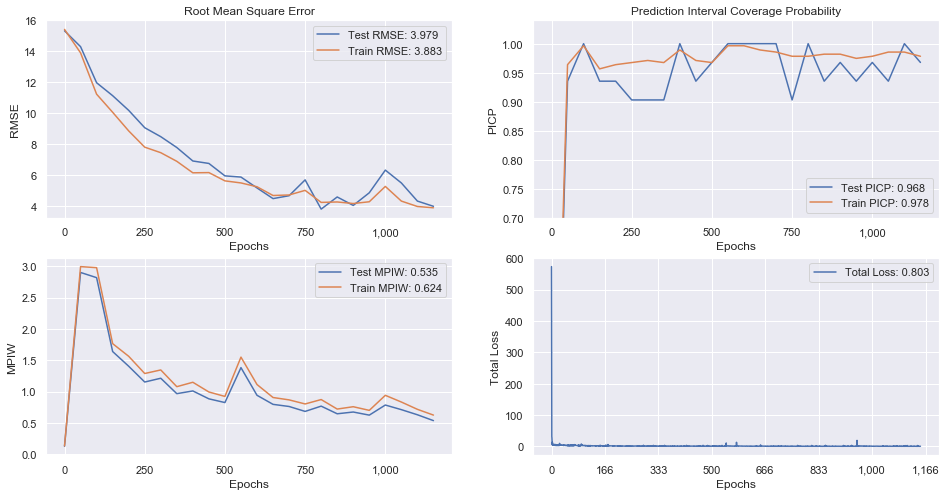

100%|██████████| 1200/1200 [00:34<00:00, 34.50it/s]


 RMSE = 3.969, PICP = 1.000, MPIW = 0.616


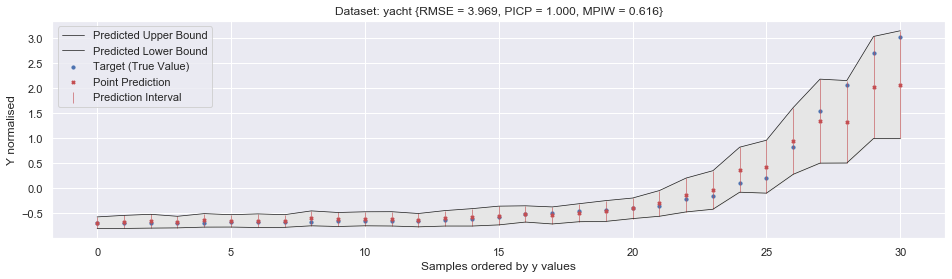

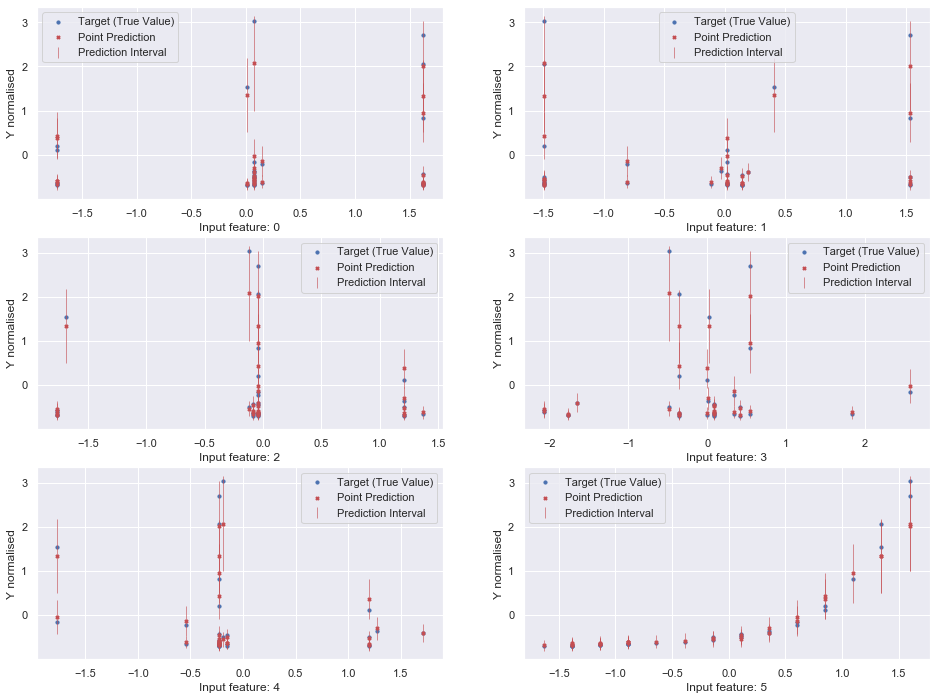

In [62]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 1200
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-3
log_every=50
ALPHA = 0.05
LAMBDA_=60
SOFTEN = 160




DATA_DIR="yacht"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

yacht_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                          alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(yacht_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(yacht_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



In [63]:
## Year

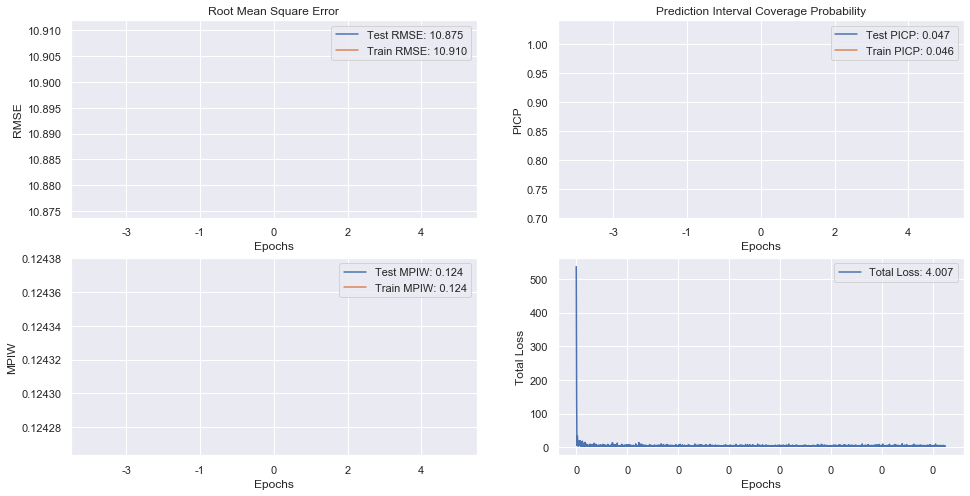

100%|██████████| 50/50 [14:19<00:00, 15.67s/it] 


 RMSE = 9.219, PICP = 0.938, MPIW = 2.315


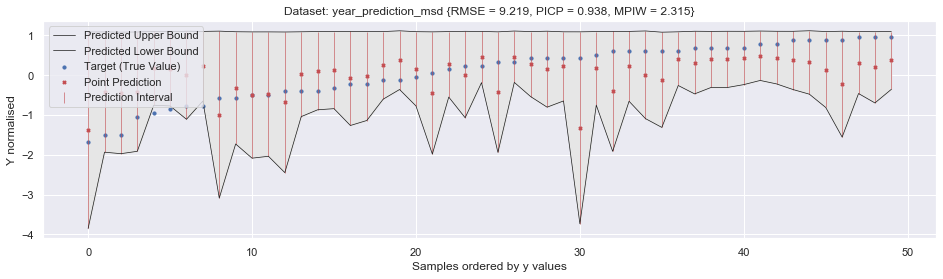

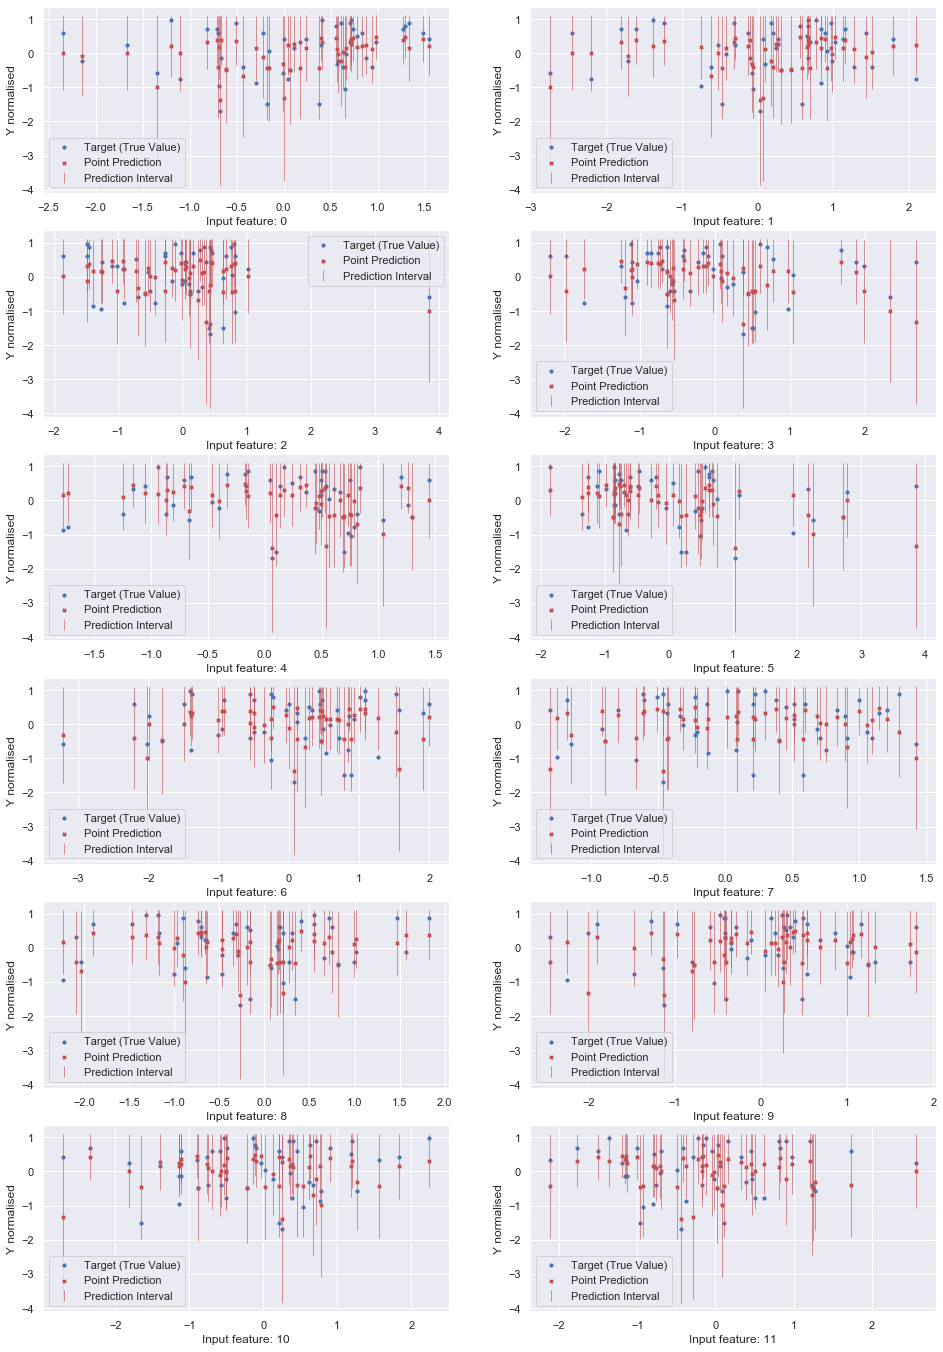

In [64]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 50
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 100
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-4
log_every=100
ALPHA = 0.05
LAMBDA_=60
SOFTEN = 160


DATA_DIR="year_prediction_msd"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

year_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale,
                          alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN)

train_dropout(year_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(year_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)

